# Collaboration and Competition

In this notebook, I'll train an agent to solve the Tennis Environment using Unity ML-Agents.

---

# Index

- [1. Setup the Environment](#1.-Setup-the-Environment)
- [2. Start the Environment](#2.-Start-the-Environment)
- [3. Examine the State and Action Spaces](#3.-Examine-the-State-and-Action-Spaces)
- [4. Define helper functions to training session](#4.-Define-helper-functions-to-training-session)
- [5. Training the Agent](#5.-Training-the-Agent)
- [6. Test Agent on Environment](#6.-Test-Agent-on-Environment)

## 1. Setup the Environment

<img align="left" width="150" src="https://www.nclouds.com/img/services/toolkit/sagemaker.png"/>

This notebook was developed on AWS SageMaker.

The kernel used is **conda_python3**

To setup this environment on SageMaker you need to run the next 3 cells.

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip -q install ./python

## 2. Start the Environment

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
from collections import deque
from agent import Agent

env_path = "envs/Tennis_Linux/Tennis.x86_64" # Linux
#env_path = "envs/Tennis_Windows_x86_64/Tennis.exe" # Windows

env = UnityEnvironment(file_name=env_path, no_graphics=True)

Running on device: cpu


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 3. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 4. Define helper functions to training session

Here we'll create a function that can be very helpful to teach the agent.

In [4]:
def rl_trainer(agents, n_episodes=2000, max_time_step=None, score_deque=100, print_range=10, early_stop=30, add_noise=False, save_model=True, verbose=False):
    """Deep Q-Learning trainer.
    Params
    ======
        agents (list): List of Agent Objects
        n_episodes (int): maximum number of training episodes.
        max_time_step (int or None): The max time step per episode, if None, the agent will training until environment is done.
        scores_deque (int): The len of score deque.
        print_range (int): range to print partials results.
        early_stop (int): Stop training when achieve a defined score respecting 10 min n_episodes.
        add_noise (bool): If True, we'll reset at each step and add_noise at each action call.
        save_model (bool): If True, we'll save the model weights when we solve the environment
        verbose (bool): If verbose true, we'll print some infos on console.
    """
    scores_window = deque(maxlen=score_deque)
    scores = np.zeros(num_agents)
    scores_episode = []
    
    for ep in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        time_step = 0
        training = True
        
        if add_noise:
            for agent in agents:
                agent.reset()

        while training:
            actions = np.array([agents[i].act(states[i], add_noise) for i in range(num_agents)])
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done        
            
            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i]) 
 
            states = next_states
            scores += rewards
            time_step += 1
            
            if isinstance(max_time_step, (int, float)):
                if time_step >= max_time_step:
                    training = False
                    
            if np.any(dones):
                break 
                
        score = np.mean(scores)
        scores_window.append(score)
        scores_episode.append(score)

        if verbose:
            print('\rEpisode {} || Avg Score: {:.2f} || Max Score: {:.2f} || Avg Score (last {} episodes): {:.2f}'.format(ep, score, np.max(scores), score_deque, np.mean(scores_window)), end="")
            if ep % print_range == 0:
                print('\rEpisode {} || Avg Score: {:.2f} || Max Score: {:.2f} || Avg Score (last {} episodes): {:.2f}'.format(ep, score, np.max(scores), score_deque, np.mean(scores_window)))
        if np.mean(scores_window) >= early_stop:
            if verbose:
                print('\nEnvironment solved in {:d} episodes! || Avg Score: {:.2f}'.format(ep, np.mean(scores_window)))
            if save_model:
                Agent.save_model(params=agents[0].get_params())
                
            break
            
    return scores_episode

## 5. Training the Agent

In the next code cells, we will train the Agent to work on environment.

Episode 100 || Avg Score: -0.00 || Max Score: 0.00 || Avg Score (last 100 episodes): -0.00
Episode 200 || Avg Score: 0.05 || Max Score: 0.09 || Avg Score (last 100 episodes): 0.0110
Episode 300 || Avg Score: 0.10 || Max Score: 0.10 || Avg Score (last 100 episodes): 0.022
Episode 400 || Avg Score: -0.00 || Max Score: 0.00 || Avg Score (last 100 episodes): 0.02
Episode 500 || Avg Score: -0.00 || Max Score: 0.00 || Avg Score (last 100 episodes): 0.02
Episode 600 || Avg Score: -0.00 || Max Score: 0.00 || Avg Score (last 100 episodes): 0.01
Episode 700 || Avg Score: 0.05 || Max Score: 0.10 || Avg Score (last 100 episodes): 0.021
Episode 800 || Avg Score: 0.05 || Max Score: 0.10 || Avg Score (last 100 episodes): 0.022
Episode 900 || Avg Score: 0.05 || Max Score: 0.10 || Avg Score (last 100 episodes): 0.022
Episode 1000 || Avg Score: -0.00 || Max Score: 0.00 || Avg Score (last 100 episodes): 0.02
Episode 1100 || Avg Score: -0.00 || Max Score: 0.00 || Avg Score (last 100 episodes): 0.01
Episod

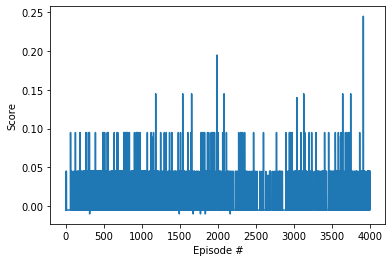

CPU times: user 5h 24min 24s, sys: 8min 34s, total: 5h 32min 58s
Wall time: 46min 48s


In [6]:
%%time

agents = [] 
for i in range(num_agents):
    agents.append(Agent(state_size=state_size, action_size=action_size, random_seed=399, memory_size=int(1e8),
                        batch_size=32, gamma=0.98, tau=1e-3, lr_actor=1e-4, lr_critic=1e-4, weight_decay=0.1,
                        actor_units=(256, 256), critic_units=(256, 256)))
    
scores = rl_trainer(agents, n_episodes=4000, print_range=100, early_stop=0.5,
                    add_noise=True, save_model=True, verbose=True)

agent = agents[0]

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Load weights

In [ ]:
agent = Agent.load_model()
agent

## 6. Test Agent on Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance.

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    action = agent.act(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()